# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 01.12.2022

Мягкий дедлайн: 23:59MSK 11.12.2022

Жесткий дедлайн: 23:59MSK 15.12.2022

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

/Users/neudachina/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California 

In [166]:
x = boston["data"]
y = boston["target"]

In [167]:
x.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [7]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

32.97408677746786

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [23]:
i = list(range(5))
i

[0, 1, 2, 3, 4]

In [188]:
def compute_biase_variance(regressor, x, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    size = x.shape[0]
    predictions = pd.DataFrame(columns=list(range(num_runs)))
    predictions[0] = [np.nan] * size
    
    indexes = np.arange(stop=size)
    
    for iteration in range(num_runs):
        bootstrap = np.random.randint(low=0, high=size, size=size, random_state=iteration)
        regressor.fit(x[bootstrap], y[bootstrap])
        
        out_of_bag = indexes[~np.isin(indexes, np.unique(bootstrap))]
        if len(out_of_bag) > 0:
            predicted = regressor.predict(x[out_of_bag])
            predictions.loc[out_of_bag, iteration] = predicted
        
    average = np.nanmean(predictions, axis=1, dtype=float)
    indexes = np.where(~np.isnan(average))[0]
    bias = np.square(average[indexes] - y[indexes]).mean()
    
    variance = np.nanvar(np.array(predictions)[indexes], axis=1, ddof=1).mean()
    
    error = np.nanmean(np.square(np.array(predictions)[indexes] - y[indexes, None]), dtype=float)
    
    return bias, variance, error


__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [195]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


names = ['linreg', 'decision tree', 'random forest']
regressors = [LinearRegression(), DecisionTreeRegressor(random_state=42), RandomForestRegressor(random_state=42)]

results = pd.DataFrame(columns=['bias', 'variance', 'error', 'difference'])

for i in range(3):
    bias, variance, error = compute_biase_variance(regressors[i], x, y)
    results.loc[names[i]] = [
        bias,
        variance,
        error,
        error - bias - variance
    ]

results

,bias,variance,error,difference
linreg,23.757837,0.936102,24.696233,0.002294
decision tree,10.257777,12.763814,22.961709,-0.059882
random forest,10.550068,2.251665,12.758206,-0.043528


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__ да, согласуются. у линейной регрессии большое смещение, но самый маленький разброс. у решающего дерева смещение почти в два раза меньше, но и огромный разброс. у рандомного леса такое же смещение, как и у одного дерева, потому что это композиция и смещение примерно такое же как и у отдельных деревьев, и разброс тоже очень маленький, практически как у линейной регрессии

еще интересно, что у рандомного леса самая маленькая ошибка, ведь это композиция довольно глубоких деревьев, лес топовый, хорошо делает :)

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

In [196]:
from sklearn.ensemble import BaggingRegressor

names = ['bagging LR', 'bagging DT', 'bagging RF']
regressors = [LinearRegression(), DecisionTreeRegressor(random_state=42), RandomForestRegressor(random_state=42)]

for i in range(3):
    bias, variance, error = compute_biase_variance(BaggingRegressor(regressors[i]), x, y)
    results.loc[names[i]] = [
        bias,
        variance,
        error,
        error - bias - variance
    ]

results

,bias,variance,error,difference
linreg,23.757837,0.936102,24.696233,0.002294
decision tree,10.257777,12.763814,22.961709,-0.059882
random forest,10.550068,2.251665,12.758206,-0.043528
bagging LR,23.731662,1.018033,24.699692,-0.050003
bagging DT,10.659440,3.361198,13.960884,-0.059754
bagging RF,11.532529,1.413930,12.852181,-0.094277


по идее, беггинг должен уменьшать разброс базового алгоритма в N раз, где N – количество базовых моделей. но у нас, видимо, модельки не то чтобы очень независимые, так что их ковариация не дает сильно уменьшаться разбросу. он даже немного увеличился в случае с линейной регрессией, потому что LR-модельки довольно стабильные к небольшим изменениям датасета и поэтому сложно сказать, что они независимые

для decision tree ситуация другая, потому что деревья очень нестабильные и сильно разнятся при небольших изменения в выборках, поэтому bagging хорошо, аж в 4 раза, уменьшил разброс, bias при этом ожидаемо особо не изменился

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [237]:
def plot_predictions(regressor, x, y, num_runs=100, num_test_objects=10, title="", lim=None):
    """
    plot graphics described above
    """
    size = x.shape[0]
    test = np.random.choice(a=size, size=num_test_objects, replace=False)
    
    predictions = pd.DataFrame(columns=list(range(num_runs)))
    predictions[0] = [np.nan] * num_test_objects
    
    indexes = np.arange(size)
    size = size - num_test_objects
    for iteration in range(num_runs):
        bootstrap = np.random.choice(a=indexes[~np.isin(indexes, test)], size=size, replace=True)
        regressor.fit(x[bootstrap], y[bootstrap])
        
        predicted = regressor.predict(x[test])
        predictions.loc[:, iteration] = predicted
    
    for i in range(num_test_objects):
        plt.scatter(x=np.full((num_test_objects,), i), y=predictions[i])
        plt.scatter(x=i, y=y[i], c='black')
    plt.title(title)
    plt.xlabel('test sample')
    plt.ylabel('predictions')
    if lim is not None:
        plt.ylim((0, lim))
    
    

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

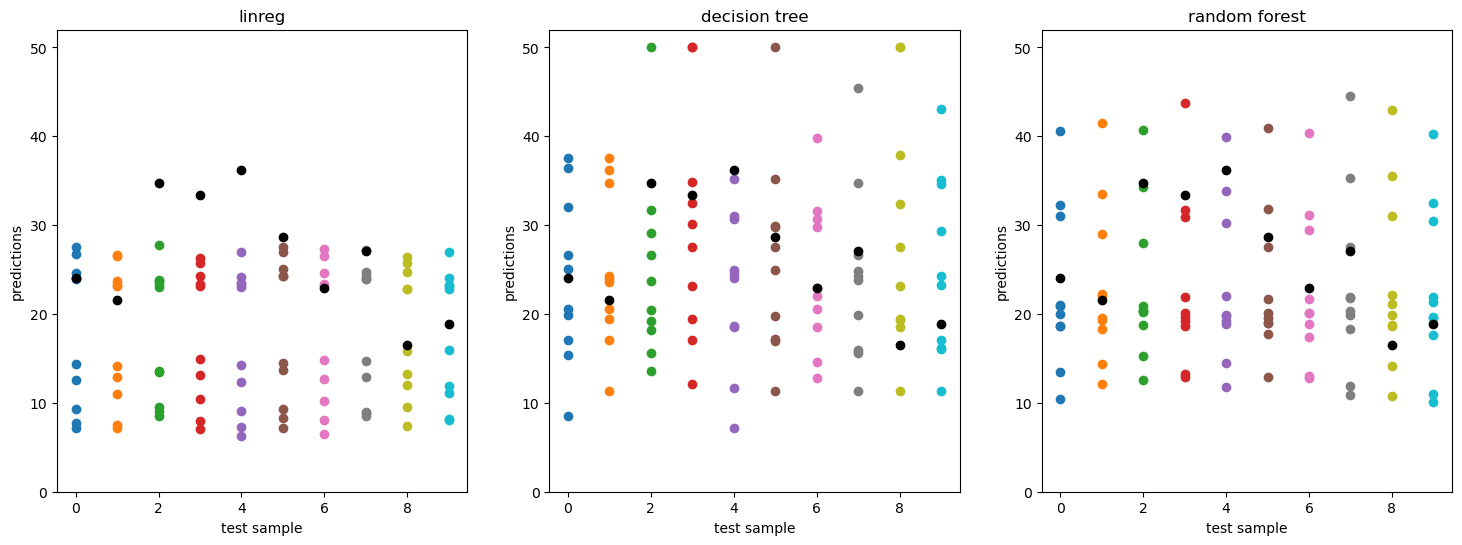

In [238]:
plt.figure(figsize = (18, 6))

regressors = [LinearRegression(), DecisionTreeRegressor(random_state=42), RandomForestRegressor(random_state=42)]
names = ['linreg', 'decision tree', 'random forest']
for i in range(3):
    plt.subplot(1, 3, i+1)
    plot_predictions(regressors[i], x, y, title=names[i], lim=52)

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__ для линейной регрессии видно, что она не захватывает некоторые реальные значения, так что смещение довольно высокое. при этом предсказанные точки в небольшом относительно других графиков интервале, то есть разброс мальый. для дерева и случайного леса верно, что они захватывают все реальные значения в интервале предсказанных, то есть смещение поменьше, примерно одинаковое. при этом разброс у решающего дерева намного больше, максимальные значения около 50, когда для дерева они меньше 45, да и начинается интервал у леса с большего значения, чем у дерева

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

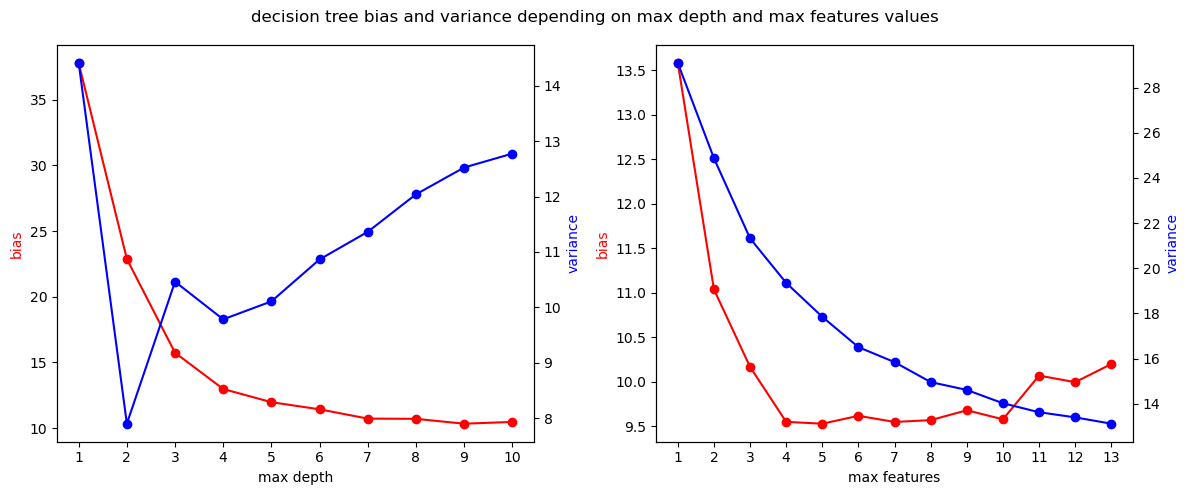

In [266]:
def double_plot(x, y1, y2, xlabel, ylabel1, ylabel2, ax):
    ax.plot(x, y1, color="red", marker="o")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel1, color="red")
    ax.set_xticks(x)

    ax2 = ax.twinx()
    ax2.plot(x, y2, color="blue", marker="o")
    ax2.set_ylabel(ylabel2, color="blue")



fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("decision tree bias and variance depending on max depth and max features values")

n = 10
bias = [None] * n
variance = [None] * n

for i in range(n):
    bias[i], variance[i], _ = compute_biase_variance(DecisionTreeRegressor(max_depth=i+1), x, y)
 
double_plot(range(1, n+1), bias, variance, "max depth", "bias", "variance", axes[0])

n = x.shape[1]
bias = [None] * n
variance = [None] * n

for i in range(n):
    bias[i], variance[i], _ = compute_biase_variance(DecisionTreeRegressor(max_features=i+1), x, y)

double_plot(range(1, n+1), bias, variance, "max features", "bias", "variance", axes[1])

plt.tight_layout()
plt.show()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

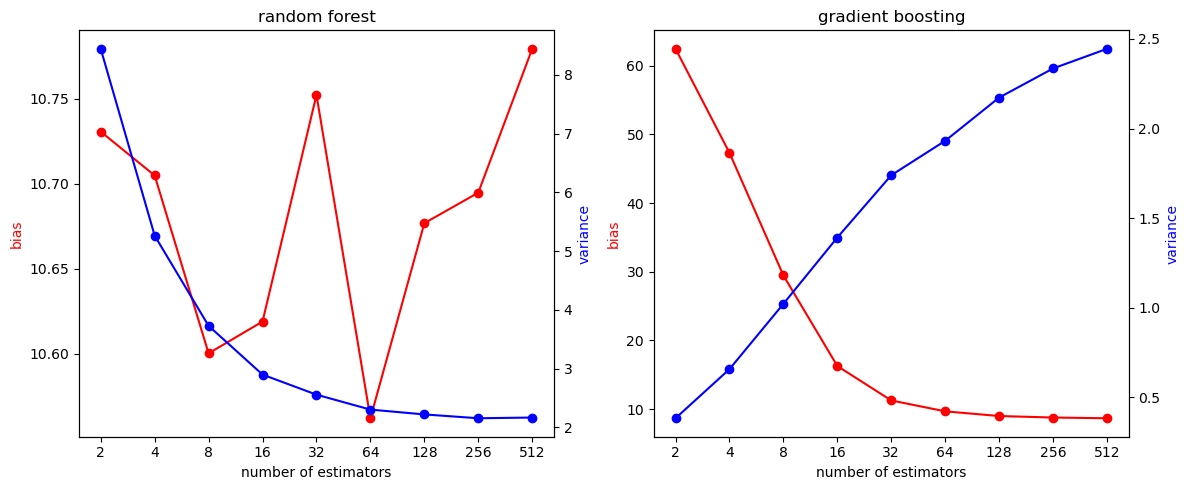

In [274]:
from sklearn.ensemble import GradientBoostingRegressor

def double_plot(x, y1, y2, xlabel, ylabel1, ylabel2, title, xticks, ax):
    ax.plot(x, y1, color="red", marker="o")
    ax.set_ylabel(ylabel1, color="red")

    ax2 = ax.twinx()
    ax2.plot(x, y2, color="blue", marker="o")
    ax2.set_ylabel(ylabel2, color="blue")
    
    ax.set_xlabel(xlabel)
    ax.set_xticks(x)
    ax.set_xticklabels(xticks)
    ax.set_title(title)


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

n = 9
bias = [None] * n
variance = [None] * n

values = 2 ** np.arange(1, n+1)

for i in range(n):
    bias[i], variance[i], _ = compute_biase_variance(RandomForestRegressor(n_estimators=values[i]), x, y)
 
double_plot(np.arange(1, n+1), bias, variance, "number of estimators", "bias", "variance", "random forest", values, axes[0])

for i in range(n):
    bias[i], variance[i], _ = compute_biase_variance(GradientBoostingRegressor(n_estimators=values[i]), x, y)

double_plot(np.arange(1, n+1), bias, variance, "number of estimators", "bias", "variance", "gradient boosting", values, axes[1])

plt.tight_layout()
plt.show()

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__ 

- решающее дерево

логично, что с увеличением максимальной глубины падает разброс, дерево обучается, в глубиной 10 переобучение еще не начинается, и поэтому с какого-то момента растер разброс, потому что они становятся очень нестабильные к небольшим изменения в датасете

так же логично, что при увеличении признаков, использующихся для поиска лучшего разбиения, у нас уменьшается разброс, ведь в самом начале, когда мы берем всего один признак, на наши деревья очень сильно влияет рандом, они могут получаться абсолютно разные. смещение тоже сначала падает, а потом растет. почему? это связано с тем, что по дефолту в sklearn при неустановленном max depth деревья обучаются, пока у нас в листьях не останутся объекты лишь одной категории. видимо, при таком условии и большом количестве рассматриваемых при поиске разделения признаков дерево начинает переобучаться, оно может в итоге получиться сильно глубоким

- случайный лес

смещение особо не меняется (можно посмотреть по масштабу, что максимальное и минмиальное значения с разницей в 2 десятых) при увеличении числа estimators, потому что это же просто усреднение всех моделей. а разброс сильно уменьшается, что логично, потому что мы увеличиваем N, так что в формуле разброс базового алгоритма делится все на бОльшее число, при этом так как это случайный лес, то отдельные деревья довольно независимые и слагаемое, отвечающее за ковариацию деревьев, не перевешивает и в итоге общий разброс уменьшается

- градиентный бустинг

смещение падает, потому что моделька обучается, класс. но при этом увеличивается разброс, потому что мы по факту при добавлении каждого нового дерева переобучаемся под обучающую выборку, так что увеличивается разброс

__11. Бонус (0.1 балла)__


Прикрепите фотографию того, как вы начали эту зиму ❄️

__Your answer here:__ https://drive.google.com/file/d/1z3jR9sh3RXpFiJhZRoZwtTLmqu29f2zO/view?usp=sharing